In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob
from IPython.display import display
import sys

In [12]:
%load_ext autoreload
%autoreload 2
sys.path.insert(0, '../../scripts')
from plot_helpers import nice_name_map, plot_scatter_with_lines, save_plot, report_figsize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
benchmark_results = []
for path in glob.glob('../../benchmarks/2021-01-08-report-sequential/*.csv'):
    benchmark_results.append(pd.read_csv(path))
benchmark_results = pd.concat(benchmark_results)

benchmark_results.sample(5)

,generation_config_i,input_strategy,input_length_1,input_change_strength,input_chunkiness,input_distribution,regen_i,repetition_i,diff_program,mpi_comm_world,micros_input,micros_precompute,micros_until_len,micros_edit_script,min_edit_length,mpi_procs,timeout_seconds
109,7,independent,100000,1,0,zipf,0,0,mpi_no_master_frontier_simd,1,20856,0,35471885,0,171228,1.0,120.0
6,3,independent,60000,1,0,zipf,0,6,sequential_frontier,1,15229,0,19970172,0,101950,NaN,NaN
231,5,independent,80000,1,0,zipf,0,46,sequential_frontier,1,17624,0,42263196,0,136526,NaN,NaN
281,0,independent,30000,1,0,zipf,0,46,sequential_frontier,1,4354,0,4025442,0,50404,NaN,NaN
53,1,independent,40000,1,0,zipf,0,40,mpi_no_master_frontier_simd,1,5587,0,5912659,0,67622,1.0,120.0


In [4]:
diff_programs = [
    'diffutils',
    'mpi_no_master_frontier_simd',
    'mpi_priority_frontier_simd',
    'sequential_frontier_simd',
]

for diff_program in diff_programs:
    assert (benchmark_results['diff_program'] == diff_program).any()

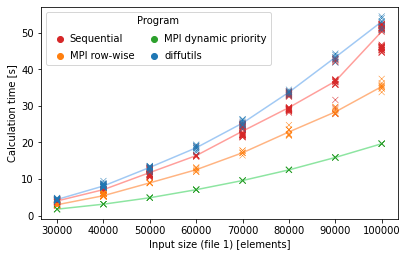

In [13]:
palette = {mpi_procs: color for mpi_procs, color in zip(sorted(benchmark_results.mpi_procs.dropna().unique()), sns.color_palette())}
fig, ax = plt.subplots(figsize=report_figsize)

temp = benchmark_results.copy()
temp['seconds_until_len'] = temp['micros_until_len'] * 1e-6
temp = temp[(temp['diff_program'].isin(diff_programs)) & (temp['input_strategy'] == 'independent')]

temp_2 = temp.groupby(['input_length_1', 'diff_program'])['seconds_until_len'].median().unstack('diff_program')

plot_scatter_with_lines(
    ax=ax,
    scatter_data=temp,
    line_data=temp_2,
    x_key='input_length_1',
    y_key='seconds_until_len',
    hue_key='diff_program',
    hue_to_label=lambda v: nice_name_map[v],
)

save_plot(fig, 'sequential-comparison')